# PA006 Bank Marketing Strategy

    **Neste ciclo temos o objetivo de encontrar primeiramente as metricas para seguirmos nossa análise.**

## Planejamento da Solução (IOT)

### Input (Entrada)

**Você foi contratado como um cientista de dados consultor, para criar um produto de dados que cria uma segmentação de clientes que direcionará a
estratpegia de marketing e os resultados esperados do seu trabalho de consultoria, são os sequintes:**

    1. Criar uma segmentação de clientes baseado em critérios claros de seleção;
    2. Tornar a segmentação de clientes acessível para o time de operações.
    3. Ensinar o time de operações sobre como usar a sua solução.
    4. Transferir o conhecimento para os Cientistas de Dados da International Bank.
    5. Recomendar 2-3 alavancas de negócio para cada segmento de clientes.

### Output (Saída)

- Ferramentas:
    - Metabase
    - Streamlit


- URL para o time de operação testar

- Download dos dados selecionados

### Tasks (Saída)

- Descrição dos dados
    - Substituição dos NA's.
        
- EDA
    - Análise Univariada.
    - Análise Bivariada
    - Detecção de outliers
    - Seleção de Features
    - Estudo do Espaço
    - Definição do Embedding
    
- Treinamento dos Algoritmos de ML.
    - Análise de Performance
    - Análise de Clustering
    - Definição dos números de clustering
    
- EDA_Insights.
    - Explicação das características dos segmentos
    
- Tabela para armazenar os clientes clusterizados.

- Criação do notebook de produção

- Arquitetura da AWS.
    - S3 para armazenar os daos
    - EC2 para armazenar o ETL e a ferramenta de visualização.
    - DB para armazenar a tabela
    - Cronjob
    - Papermil
 

**Descrição dos Dados**

CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases 

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently
purchased, 0 = not frequently purchased)

ONEOFF_PURCHASES_FREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASES_INSTALLMENTS_FREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASH_ADVANCE_FREQUENCY : How frequently the cash in advance being paid

CASH_ADVANCE_TRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRC_FULL_PAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

# 0.0 Imports

In [46]:
import numpy   as np
import pandas  as pd
import seaborn as sns

#import umap.umap_ as umap

from matplotlib          import pyplot               as plt
from plotly              import express              as px
from sklearn             import cluster              as c
from sklearn             import metrics              as m
from sklearn             import preprocessing        as pp
from sklearn.metrics     import davies_bouldin_score as db
from sklearn.cluster    import KMeans



#from sklearn import clustering

from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set(rc={'figure.figsize':(20,10)})
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv( '../data/raw/cc_general.csv' )

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Columns Rename

In [5]:
df1.columns = df1.columns.str.lower()
df1.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 1.2. Data Dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 8950
Number of cols: 18


## 1.3. Data types

In [7]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

In [9]:
df1.isna().sum() / df1.shape[0]

cust_id                             0.000000
balance                             0.000000
balance_frequency                   0.000000
purchases                           0.000000
oneoff_purchases                    0.000000
installments_purchases              0.000000
cash_advance                        0.000000
purchases_frequency                 0.000000
oneoff_purchases_frequency          0.000000
purchases_installments_frequency    0.000000
cash_advance_frequency              0.000000
cash_advance_trx                    0.000000
purchases_trx                       0.000000
credit_limit                        0.000112
payments                            0.000000
minimum_payments                    0.034972
prc_full_payment                    0.000000
tenure                              0.000000
dtype: float64

## 1.5. Replace NA

* No primeiro ciclo assumimos como erro as NA's
* No segundo ciclo, assumimos que os NA's devem ser tratados

In [10]:
df1 = df1.dropna( subset=['minimum_payments','credit_limit'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )
# Mostrando a relevancia dos valores NA's excluidos = 0.04

Removed data: 0.04


In [11]:
df1[['credit_limit', 'minimum_payments']].isna().sum()

credit_limit        0
minimum_payments    0
dtype: int64

In [12]:
# Encontramos cerca de 313 customers com valores Na's em pagamento minimo da fatura e 1 cliente sem limite de credito.
# optei em não descartar esses clientes.

#df1 = df1.fillna(0) # substituindo valores NaN por zero
df1.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## 1.6. Change dtypes

In [13]:
num_attributes = df1.select_dtypes(include=('int64', 'float64'))
cat_attributes = df1.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))
num_attributes.shape # Verificando o tamanho do novo df para os valores numericos (8936 linhas e 17 colunas)

(8636, 17)

### The First E.D.A → Variable analysis

In [14]:
# Analise exploratoria
# quando vemos que a mediana é menor que a media, significa que os valores estão abaixo dos valores proximo a media
# ou seja, ocorrem com mais frequencia abaixo da media, skewness negativa

In [15]:
# Nesse momento passamos por todos os 4 momentos da estatistica

#1. Estimativa de Localização
#    1. Média
#    2. Mediana
#    3. Mínimo
#    4. Máximo
#
#2. Estimativa de Variabilidade
#    1. Desvio
#    2. Variância
#    3. Devio Padrão
#    4. Range (intervalo)
#    
#3. Skewness
#4. Kurtosis
    

In [16]:
# Estimadores de localização (media, mediana, min, max)
est1 = pd.DataFrame(num_attributes.apply( np.mean )).T # para transpor devemos transformar num DF
est2 = pd.DataFrame(num_attributes.apply( np.median )).T
est3 = pd.DataFrame(num_attributes.apply( np.min )).T
est4 = pd.DataFrame(num_attributes.apply( np.max )).T

# Estimadores de variabilidade (desvio padrão, range)
est5 = pd.DataFrame(num_attributes.apply( np.std )).T
est6 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T

# Skewness and Kurtosis
est7 = pd.DataFrame(num_attributes.apply( lambda x: x.skew()  )).T
est8 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate and rename to columns
m1 = pd.concat( [est3, est4, est6, est1, est2, est5, est7, est8 ]).T.reset_index() #reunindo as metricas
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'desvio_padrao', 'skewness', 'kurtosis']

# Quantile
#quartis = num_attributes.apply(lambda x: np.quantile(x, q=[0.25, 0.50, 0.75])).T.reset_index()
#quartis.columns = ['attributes', 'Q1', 'Q2', 'Q3']

# Percentis
quartis = num_attributes.apply(lambda x: np.percentile(x, q=[10, 25, 50, 75, 95, 99])).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']


# Merge
m2= pd.merge(m1, quartis, how='inner', on='attributes')
m2

,attributes,min,max,range,mean,median,desvio_padrao,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.000000,19043.13856,19043.138560,1601.224893,916.855459,2095.449969,2.374254,7.553876,29.093764,148.095189,916.855459,2105.195853,5936.635587,9369.550879
1,balance_frequency,0.000000,1.00000,1.000000,0.895035,1.000000,0.207685,-2.084161,3.369586,0.545455,0.909091,1.000000,1.000000,1.000000,1.000000
2,purchases,0.000000,49039.57000,49039.570000,1025.433874,375.405000,2166.982511,8.055789,108.677684,0.000000,43.367500,375.405000,1145.980000,4060.092500,9127.092000
3,oneoff_purchases,0.000000,40761.25000,40761.250000,604.901438,44.995000,1684.210284,9.935776,160.121308,0.000000,0.000000,44.995000,599.100000,2728.372500,6783.896500
4,installments_purchases,0.000000,22500.00000,22500.000000,420.843533,94.785000,917.192075,7.216133,94.193373,0.000000,0.000000,94.785000,484.147500,1800.000000,3916.483000
5,cash_advance,0.000000,47137.21176,47137.211760,994.175523,0.000000,2121.335473,5.139629,52.143523,0.000000,0.000000,0.000000,1132.385490,4721.415498,9681.634354
6,purchases_frequency,0.000000,1.00000,1.000000,0.496000,0.500000,0.401249,0.033041,-1.638001,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.000000,1.00000,1.000000,0.205909,0.083333,0.300036,1.504234,1.058206,0.000000,0.000000,0.083333,0.333333,1.000000,1.000000
8,purchases_installments_frequency,0.000000,1.00000,1.000000,0.368820,0.166667,0.398070,0.487753,-1.419279,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.000000,1.50000,1.500000,0.137604,0.000000,0.201780,1.795915,3.184233,0.000000,0.000000,0.000000,0.250000,0.583333,0.833333


In [154]:
# Mediana, Moda, < Media = assimetria → deslocamento a direita = Positiva (media maior que mediana)

In [155]:
 ### Outliers
### Balance: Quanto eu já gastei no cartão ( Fatura atual )
### Segunda Opção sobre o Balance ( Saldo ): Fatural atual - limite do cartão. O quanto falta de limite disponível para compra.

## Balance Frequency: Frequência de uso do cartão ( usabilidade )

## Purchases: O valor gasto no cartão acumulado dos últimos 6 meses ( a soma de todos os valores quando a pessoa passou o cartão na máquina de cartão )

## Purchases On-Off: A soma de todas as compras pagas 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Installmente Purchases: A soma de todas as compras pagas em mais de 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Cash Advance: Valor do saque do limite do cartão de crédito, acumulado dos últimos 6 meses.
## Um adiantamento em dinheiro é basicamente um empréstimo de curto prazo oferecido pelo emissor do 
## cartão de crédito . Quando você pega um adiantamento em dinheiro, está tomando dinheiro emprestado 
## contra a linha de crédito do seu cartão.

## Purchases Frequency: Um valor de 0 a 1 que identifica a frequência de compra do cliente

## Cash Advance Frequency: A frequência com que o cliente faz retiradas de dinheiro do seu cartão de crédito.

## Cash Advance TRX: A quantidade de saques da conta do cartão de crédito

## Purchases TRX: A quantidade de compras realizadas no cartão de crédito.

## Credit Limit: O limite do cartão de crédito.

## Payments: O valor pago além do mínimo da fatura ( não necessariamente a fatura toda )

## Minimum Payments: O valor mínimo pago da fatura

## Por exemplo:
## Fatura total ( Payments ): 3000 
## Pagamento mínimo ( mínimum payments ): 2000 
## Pagamento efetivo de R$2.500

## Payment = 500 
## Minimum payments = 2000
## Pagamento efeito = Payments + Minimum Payments

## Tenure: O tempo de posse do cartão em meses ( O tempo em que a pessoa é cliente do banco )

### Validaçãos dos possiveis Outliers

In [156]:
# Validando os valores máximos e mínimos do conjunto de dados
#Q1 = np.quantile( num_attributes['purchases'], q=[0.25, 0.50, 0.75 ])[0]
#Q2 = np.quantile( num_attributes['purchases'], q=[0.25, 0.50, 0.75 ])[1]
#Q3 = np.quan#tile( num_attributes['purchases'], q=[0.25, 0.50, 0.75 ])[2]

In [157]:
#Validando o outliers
# todo valor acima do maximo (3 quartil) será outlier
 
#b = Q3 - 1.5 * (Q3-Q1)
#c = Q3 + 1.5 * (Q3-Q1)

#O resultado mostra um valor menor que o maximo valor da tabela, ou seja, o resultade abaixo 
#é o maximo valor do Quartil 3 (ultima linha do boxplot)
#print(f'O menor valor assumido dentro dos quartis é {b} e o maior valor dentro dos quartis é {c}.\nQualquer valor diferente desses seram outliers')

In [158]:
# Nos Percentis, podemos analisar onde e quantos são os clientes dentro desse range de valores.
# No P99, mostramos que, 99% dos nossos clientes estão localizados abaixo do valor 9369,00
# ou seja, 1% ou (num_attributes.shape[0]*0.01) 86 clientes gastam acima de 9369 (podem ser outliers)
#num_attributes['purchases'].max()

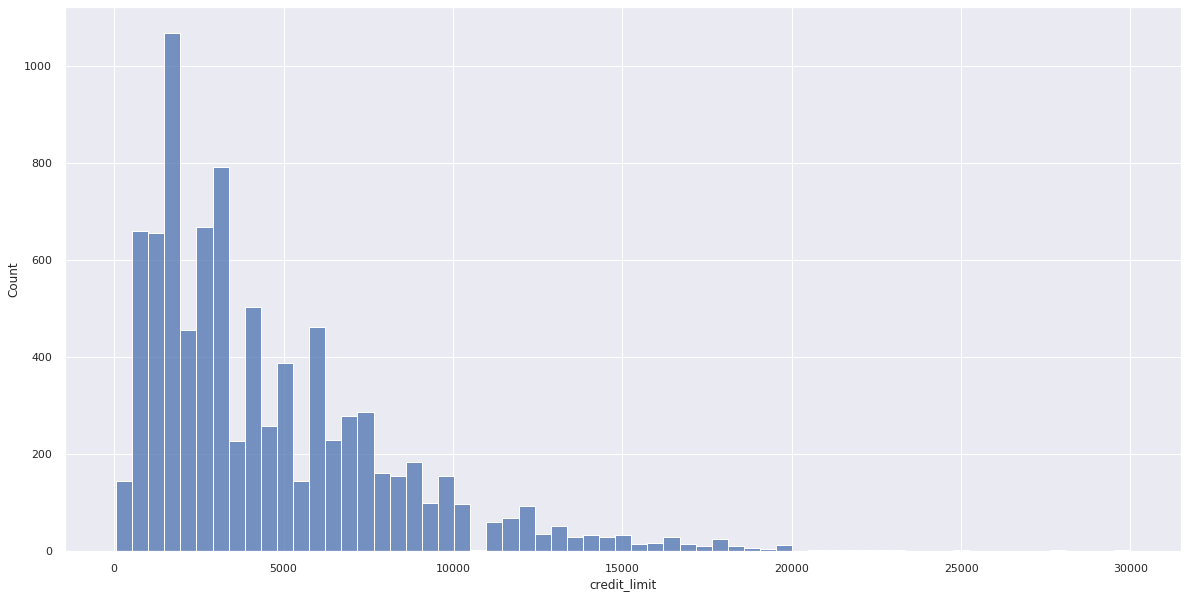

In [17]:
#plt.figure(figsize=(20, 10))
sns.histplot(num_attributes['credit_limit']);

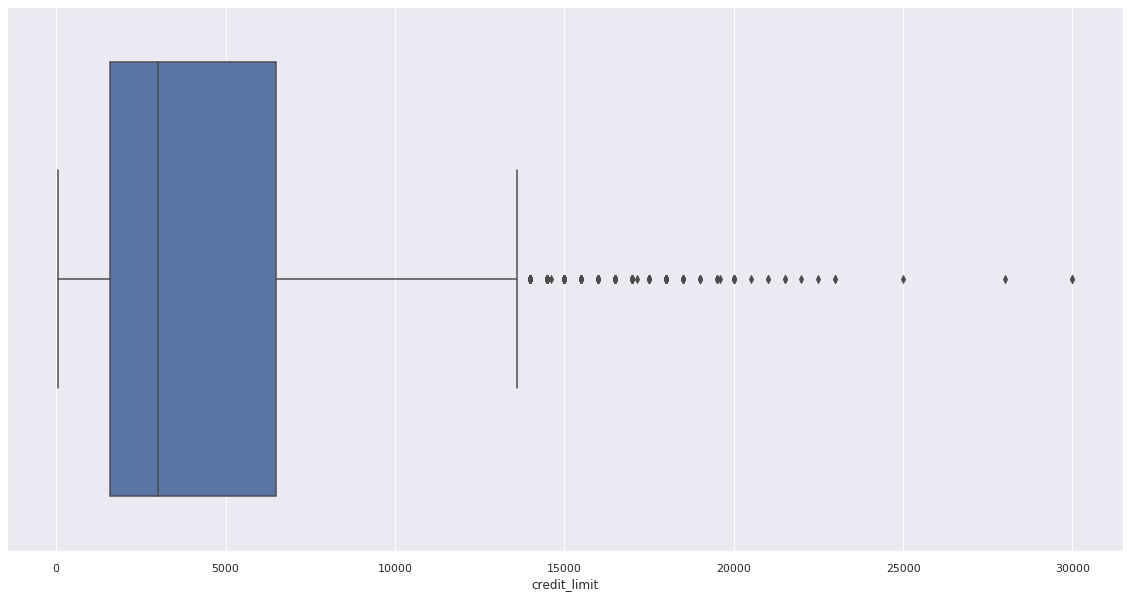

In [19]:
#plt.figure(figsize=(20, 10))
sns.boxplot( x='credit_limit', whis=1.5,  data=num_attributes);
# por padrão o whis do boxplot é igual a 1.5, porém, conseguimos 
# alterar esse valor (whis= x) elevando ou diminuindo o valor maximo do 
# boxplot e por consequencia, assumindo um range maior para a 
# definição de outliers.

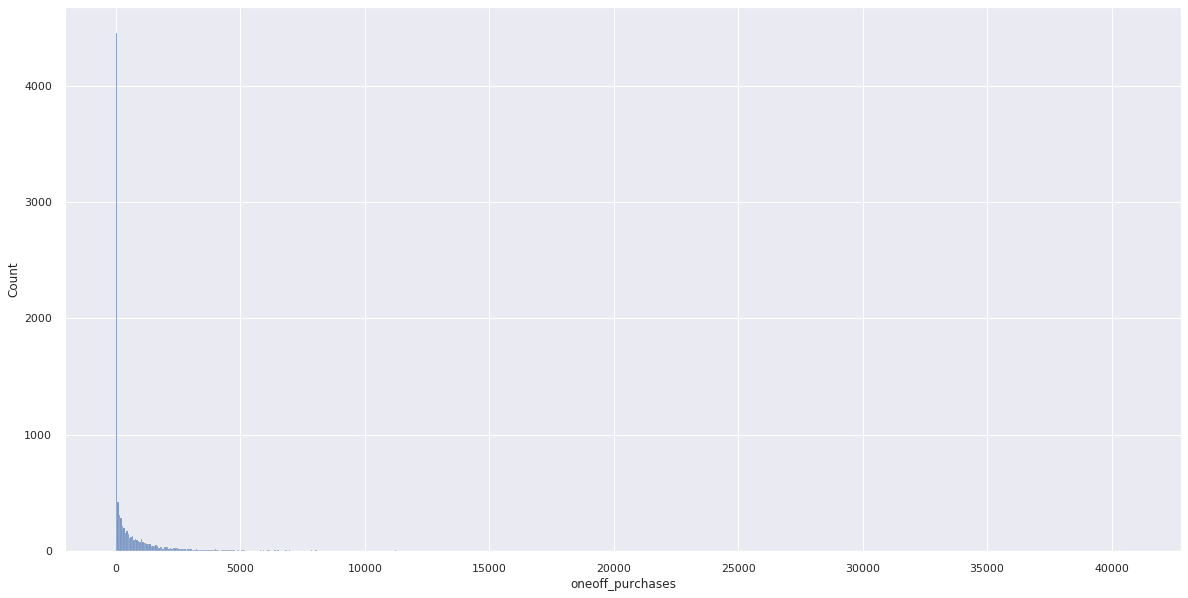

In [20]:
#plt.figure(figsize=(10, 5))
sns.histplot(num_attributes['oneoff_purchases']);

### Skewness

Medida de assimetria da distribuição dos dados, em relaçãoa uma distribuição normal.
A distribuição normal tem simetria a média, ou seja, 50% dos dados estão a esquerda e a direita
Skewness Positiva e Negativa
    - Mediana > Média: Deslocamento para a esquerda = Skewnes Negativa
    - Mediana < Média: Deslocamento para a direita = Skewnes Positiva
        

### Kurtosis

* Kurtosis evidência as caudas longas (probabilidade de acontever valor extremos, sejam mínimos ou máximos)

### Desvio padrão

- Estimativa de dispersão ou variabilidade
- Mede a dispersão dos valores do conjunto de dados em torno de uma estimativa de localização ( média )

a = [ 1, 5, 7, 10, 15], media = 7.6

- Desvio:
    1 - 7.6 = ( - 6.6 )
    5 - 7.6 = ( - 2.6 )
    7 - 7.6 = ( - 0.6 )
    10 - 7.6 = ( + 2.4 )
    15 - 7.6 = ( + 7.4 )

- Variância:
    1 - 7.6 = ( - 6.6 )**2 = 43.56
    5 - 7.6 = ( - 2.6 )**2 = 6.76
    7 - 7.6 = ( - 0.6 )**2 = 0.36
    10 - 7.6 = ( + 2.4 )**2= 5.76
    15 - 7.6 = ( + 7.4 )**2 = 54.76
    
    ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 ) = 22.24 L^2

- Desvio Padrão: A raíz quadrada da variância
    1 - 7.6 = ( - 6.6 )**2 = 43.56
   5 - 7.6 = ( - 2.6 )**2 = 6.76
    7 - 7.6 = ( - 0.6 )**2 = 0.36
    10 - 7.6 = ( + 2.4 )**2= 5.76
    15 - 7.6 = ( + 7.4 )**2 = 54.76
    
    np.sqrt( ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 - 1) = 27.79 ) = 5.27

np.sqrt ( ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 - 1) )

### Quartis (Quantile)

* Um quartil é qualquer um dos três valores que divide o conjunto de dados ordenado em 4 partes iguais, e assim cada parte representa 1/4 da amostra original.

**Primeiro Quartil** ( quartil inferior): É o valor do conjunto de dados que delimita os 25% menores valores.

**Segundo Quartil** (quartil do meio): É o valor do conjunto de dados que delimita os 50% menores valores.

**Tericeiro Quartil** (quartil do Superior): É o valor do conjunto de dados que delimita os 75% menores valores.

### Percentis

* Os Percentis são medidas que dividem a amostra ordenada em 100 partes, cada uma com uma porcentagem de dados aproximadamente igual.

- O percentil 1 → determina o 1% dos menores valores do conjunto de dados (1% dos dados são menores que P1)
- O Percentil 10 → determina os 10% dos menores valores do conjunto de dados (10% dos dados são menores que P10)
- O Percentil 25 → determina os 25% dos menores ou iguais valores do conjunto de dados (25% dos dados são menores que P10) = 1º Quartil
- O Percentil 50 → determina os 50% dos menores ou iguais valores do conjunto de dados (50% dos dados são menores que P10) = 2º Quartil
- O Percentil 75 → determina os 75% dos menores ou iguais valores do conjunto de dados (75% dos dados são menores que P10) = 3º Quartil

**_Todo quartil e percentil são métricas de proporções, todo quartil e percentil tem distancias iguais, que é uma distancia de uma unidade do seu valor, ou seja, tamanhos iguais._**

### Mínimo

* Menor valor de um conjunto de dados

### Máximo

* Maior valor de um conjunto de dados

### Intervalo

* A diferença entre o maior e o menor valor do conjunto de dados
* Escala dos dados

### Boxplot

***O BoxPlot nos mostra a representação visual dos Quartis, mostrando os quatro principais atributos de uma variável: Centro, Variabilidade, Assimetria e Outliers.***

- geralmente essa visualização é muito ruim, para melhorar isso calcular os valores e assim mostrar isso em valores absolutos
- geralmente essa visualização é muito ruim, para melhorar isso calcular os valores e assim mostrar isso em valores absolutos

np.quantile( num_attributes['credit_limit'], q=[0.25, 0.50, 0.75, 0.95]

In [162]:
#plt.figure(figsize=(20, 10))
#sns.boxplot( y='balance', data=num_attributes);
#sns.boxplot( x='balance_frequency', data=num_attributes);
#→ se mudar o eixo para X plotamos numa melhor visualização

- Como saber quais os valores acima de 75%?

maximum = Q3 + 1.5 * (Q3 - Q1)
→ o valor do **whis é opcional, podendo variar entre 1.5 e 2.5 - permitindo um "range" entre os outliers**
ex.: Q3 = 6500
       Q1 = 1600
       Q2 = 3000

Na formula acima, encontramos o resultado igual a 13850, ou seja, qualquer valor acima deste será um outlier. A linha limite do Boxplot será o quantil 95, o que seria isso?

In [163]:
## Regras da plotagem do boxplot: Calculo das barras do boxplot
#
#minimum = Q1 - 1.5 * (Q3 - Q1)
#maximum = Q1 + 1.5 * (Q3 - Q1)
#
#if minimum < valor_minimo_do_conjunto_de_dados:
#     print(num_attributes['credit_limit'].min()) 
#else:
#     print(minimum)
#
#if maximum > valor_maximo_do_conjunto_de_dados:
#     print(valor_maximo_do_conjunto_de_dados) 
#else:
#     print(maximum)

### Violinplot

***Violinplot mostra os 5 principais atributos de uma variável: Centro, Variabilidade, Assimetria, Outliers e Desnidade.***

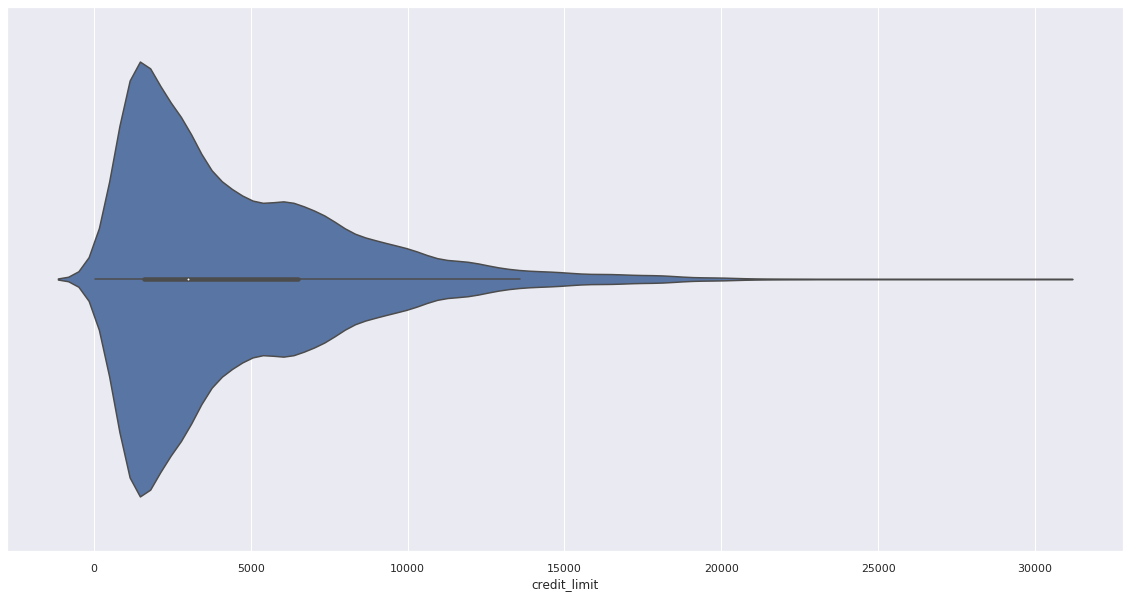

In [21]:
#plt.figure(figsize =(20, 10))
sns.violinplot(x='credit_limit', data=num_attributes);

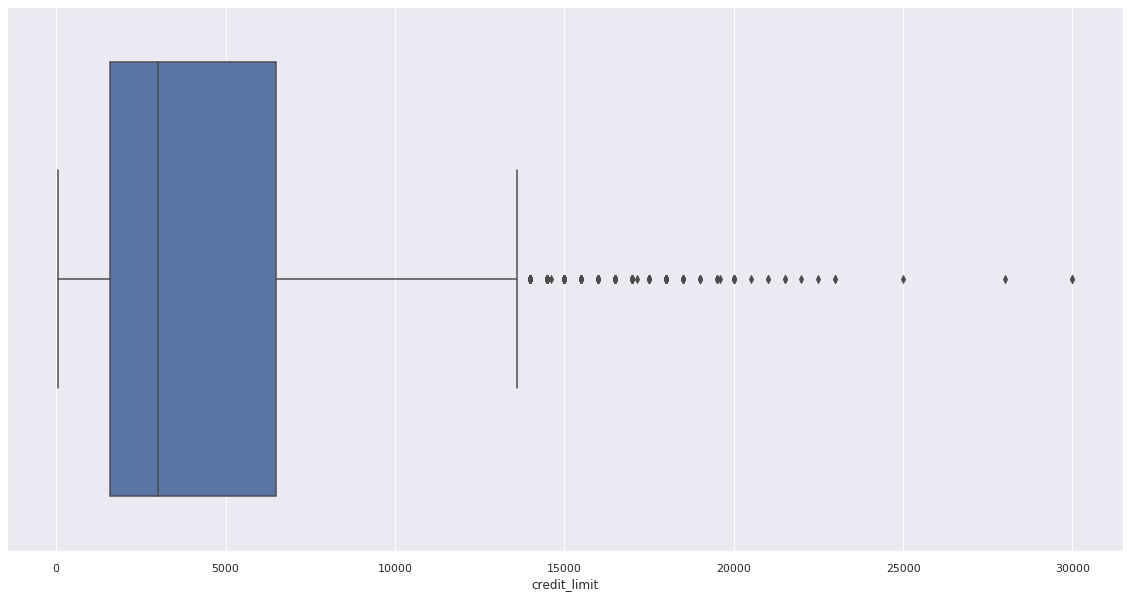

In [22]:
#plt.figure(figsize =(20, 10))
sns.boxplot(x='credit_limit', data=num_attributes);

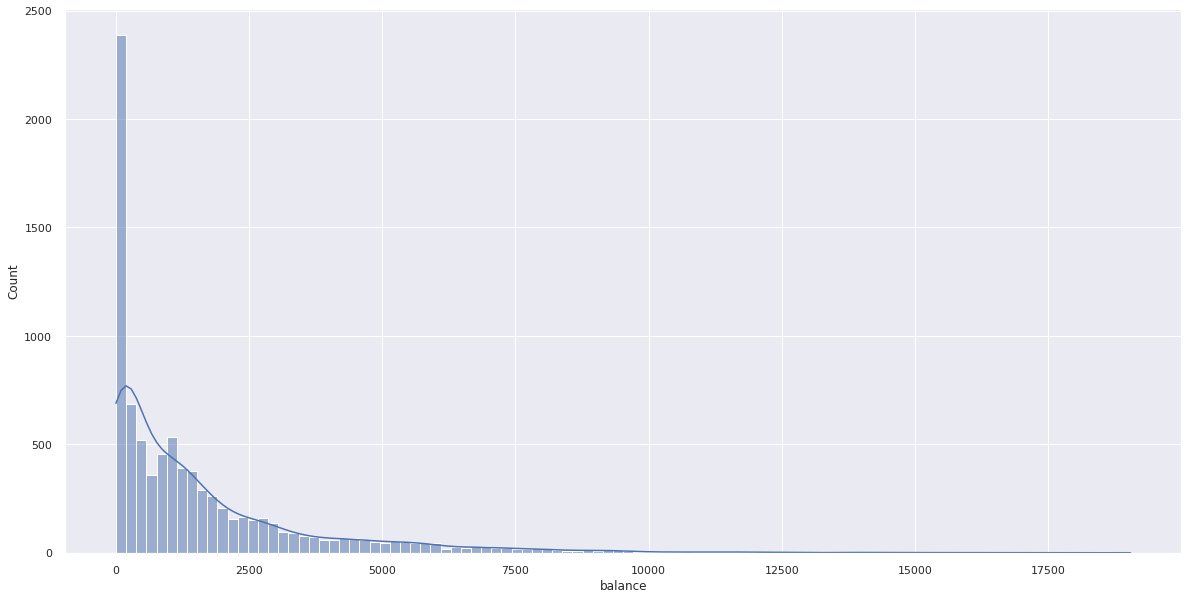

In [23]:
#sns.histplot(x='credit_limit', kde=True, data=num_attributes);
sns.histplot(x='balance', kde=True, data=num_attributes);

## 1.6.2 Categorical attributes

In [167]:
# Nesse conjunto de dados não temos valoresw categoricos

## 1.7. Descriptive Statistics

Cycle 2

# 2.0 Data Filtering

In [24]:
df2 = df1.copy()

# 3.0 Feature Engineering

In [25]:
# Features |Candidatas para eliminação

# → cash_advance_frequency : Incerteza do calculo utilizado para chegar nesse frequencia (qualo periodo)
# → purchases_instalments_frequency: Nunhma dessas requencias tem explicito o periodo
# → tenure: Não traz informações úteis

# Obs.: Variaveis do tipo 'media' não é muito interessante para o time de negocio

In [64]:
df3 = df2.copy()

In [65]:
# 

# Se houve compra com pagamento avista ou não
df3['one_payment'] = df3['oneoff_purchases'].apply(lambda x: 0 if x == 0.00 else 1)

# Gasto médio por transação de compra
df3['avg_ticket_purchases'] = df3['purchases'] / df3['purchases_trx']

# Valor total gasto (saque + cartão) / Quantidade total de transações
df3['avg_ticket_expenses'] = (df3['purchases'] + df3['cash_advance']) / (df3['purchases_trx'] + df3['cash_advance_trx'])

# Soma das despesas / soma dos pagamentos
df3['debt_rate'] = (df3['purchases'] + df3['cash_advance']) / (df3['payments'] + df3['minimum_payments'])

# Percentual do uso do limite do cartão
df3['credit_limit_rate'] = (df3['purchases'] + df3['cash_advance']) / (6 * df3['credit_limit'])


df3 = df3.fillna( 0 ) # substituindo os NA's por 0
## Classificar o debt_rate
#
## Classificar o credit_limit_rate
#
## Pessoas → Cartão → Compra
## quantidade de uso (quantas vezes a pessoa usou o cartão)
##                   (quanto do limite disponivel ela usou)
##                   (qual o volume de uso (dinheiro))
##                   ()
#
#


In [66]:
df3.head() # o conjunto de dados é uma query relativa ao comportamento das compras dos clientes com o cartão de creditos
# Neste conjunto temos uma certa dificuldade de criar fetures pelo fato de
# ja termos uma conjunto com query elaboradas anteriromente
# Podemos então combinar essas features para analisar seu 
# copmportamento em relação ao conjunto de dados

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,one_payment,avg_ticket_purchases,avg_ticket_expenses,debt_rate,credit_limit_rate
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,0,47.700000,47.700000,0.279510,0.015900
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,0.000000,1610.736371,1.244924,0.153403
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,1,64.430833,64.430833,0.618857,0.017182
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12,1,16.000000,16.000000,0.017332,0.002222
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12,0,166.660000,166.660000,0.350190,0.123452


In [28]:
len( df3['cust_id'].unique() )

8636

### Analise de Fato - Dimensão (construindo features)

Fato-Dimensao by Ralph Kimbal
Snowplow by
Snowflake → banco de dados

Compra = Fato ( Soma, Contar, Maior, Menor, Media, Mediana )
Cliente entrou na base = Fato
Devolução = Fato
→ Comportamento do Cliente/usuario


Dimensao

Tempo( Ano, mes, dia, hora, minuto )
Espaco( localização, região, lat, long, bairro, rua )
Produto( Nome, Tipo, Categoria, Preço, Condição de compra )
Marketing( Organica(quando o cliente chega na empresa por conta de auto-pesquisa), Paid ( Facebook, Google, Criteo ))

Feature Store = 
Custos de Marketing, Quantidade de Cliente, CAC, Numeros de campanhas, user_id, campaing_id, product_id

vendas, descontos, sales_last_30_days, sales_last_15_days → Features e métrica criadas (engineering feature)

CAC = Custo de Aquisição por Cliente


=====================
Feature Store
=====================
train.yml → query
{'features_store': ['age', 'last_purchaes']}
O arquivo yml é uma query gigante onde recebemos toda a "Feature Store" (query das features criadas)
yml → dicionario craido com as features e o modelo de ml escolhido e todo o processo de tratamento dos dados
 

# 4.0 EDA (Space Study)

In [67]:
df4 = df3.copy()

# 5.0 Data Preparation

In [68]:
df5 = df4.copy()

In [ ]:
FINALIZAMOS A AUL 59 ANALISANDO AS NOVAS FEATURES CRIADAS E VERIFICANDO SE EXITE ANECESIDADE DE REESCALA

In [72]:
df5.apply(np.max) # → verificando a necessidade de resscala

cust_id                              C19190
balance                                   1
balance_frequency                         1
purchases                                 1
oneoff_purchases                          1
installments_purchases                    1
cash_advance                              1
purchases_frequency                       1
oneoff_purchases_frequency                1
purchases_installments_frequency          1
cash_advance_frequency                  1.5
cash_advance_trx                          1
purchases_trx                             1
credit_limit                              1
payments                                  1
minimum_payments                          1
prc_full_payment                          1
tenure                                    1
one_payment                               1
avg_ticket_purchases                    inf
avg_ticket_expenses                     inf
debt_rate                           95.2426
credit_limit_rate               

In [74]:
# Variavel Normal + Sem outlier → Standart Scaler ( x - mean / std )
# Variavel Normal + com outlier → Robust Scaler ( x - Q1 / (Q3 - Q1) )
# Variavel Não Normal           → Min-Max Scaler ( x - mim / (max - min) )
# → o min-max scaler traz os valores para um range entre 0 e 1

# uso do mim-max scaler
mm = pp.MinMaxScaler()

df5['balance'] = mm.fit_transform(df5[['balance']]) 
df5['purchases'] = mm.fit_transform(df5[['purchases']]) 
df5['oneoff_purchases'] = mm.fit_transform(df5[['oneoff_purchases']])
df5['installments_purchases'] = mm.fit_transform(df5[['installments_purchases']]) 
df5['cash_advance'] = mm.fit_transform(df5[['cash_advance']]) 
df5['cash_advance_trx'] = mm.fit_transform(df5[['cash_advance_trx']]) 
df5['purchases_trx'] = mm.fit_transform(df5[['purchases_trx']]) 
df5['credit_limit'] = mm.fit_transform(df5[['credit_limit']]) 
df5['payments'] = mm.fit_transform(df5[['payments']]) 
df5['minimum_payments'] = mm.fit_transform(df5[['minimum_payments']]) 
df5['tenure'] = mm.fit_transform(df5[['tenure']]) 



In [ ]:
avg_ticket_purchases                    inf
avg_ticket_expenses                     inf
debt_rate                           95.2426
credit_limit_rate 

In [50]:
# sns.displot(df5['balance'], height=10);# Aqui mosta que a distribuição não é normal
# Vamos usar o min-max scaler

In [53]:
# Teste do min-max scaler
# df5.apply(np.min) → para saber se funcionou, todos os valores devem ser = 0
# df5.apply(np.max) → para saber se funcionou, todos os valores devem ser = 1

cust_id                             C19190
balance                                  1
balance_frequency                        1
purchases                                1
oneoff_purchases                         1
installments_purchases                   1
cash_advance                             1
purchases_frequency                      1
oneoff_purchases_frequency               1
purchases_installments_frequency         1
cash_advance_frequency                 1.5
cash_advance_trx                         1
purchases_trx                            1
credit_limit                             1
payments                                 1
minimum_payments                         1
prc_full_payment                         1
tenure                                   1
dtype: object

In [51]:
df5.head(3)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.0,0.083333,0.00,0.00000,0.005587,0.031720,0.003978,0.001826,0.000000,1.0
1,C10002,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.0,0.000000,0.25,0.03252,0.000000,0.232053,0.080892,0.014034,0.222222,1.0
2,C10003,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.0,0.000000,0.00,0.00000,0.033520,0.248748,0.012263,0.008210,0.000000,1.0


# 6.0 Feature Selection

In [75]:
# dropando a coluna "cust_id" → Neste momento ela não é importante para a análise
cols_drop = ['cust_id'] 
X = df5.drop( cols_drop, axis=1 ) # usado apenas no ciclo 01 para obtençao da métrica
# X = df1.drop( columns=cols_drop ) método alternativo

In [76]:
X.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,one_payment,avg_ticket_purchases,avg_ticket_expenses,debt_rate,credit_limit_rate
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.00,0.00000,0.005587,0.031720,0.003978,0.001826,0.000000,1.0,0,47.700000,47.700000,0.279510,0.015900
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.25,0.03252,0.000000,0.232053,0.080892,0.014034,0.222222,1.0,0,0.000000,1610.736371,1.244924,0.153403
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.00,0.00000,0.033520,0.248748,0.012263,0.008210,0.000000,1.0,1,64.430833,64.430833,0.618857,0.017182
4,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.00,0.00000,0.002793,0.038397,0.013373,0.003204,0.000000,1.0,1,16.000000,16.000000,0.017332,0.002222
5,0.095038,1.000000,0.027188,0.000000,0.059257,0.000000,0.666667,0.000000,0.583333,0.00,0.00000,0.022346,0.058431,0.027602,0.031506,0.000000,1.0,0,166.660000,166.660000,0.350190,0.123452


In [36]:
# Analisando apenas duas features 
#X = X.loc[:, ['balance', 'credit_limit']]

In [37]:
#sns.scatterplot( x='balance', y='credit_limit', data=X) ;
# Vemos que os dados estão muito misturados entre eles mesmo

# 7.0 Hyperparameter Fine-Tunning

In [77]:
df7 = df5.copy()

## 7.1. K-Means

In [78]:
#from sklearn             import cluster              as c

from sklearn.cluster import KMeans
#from sklearn import clustering
clusters = [2, 3, 4, 5, 6, 7, 8 ]

silhouette_list = []
davies_list = []

for k in clusters:
    # Model definition
    kmeans_model = c.KMeans( n_clusters=k )
    
    # model training
    kmeans_model.fit( X )
    # X é o df
    
    # model predict
    labels = kmeans_model.predict( X )
    # agrupando o cluster
    
    # model performance
    sil = m.silhouette_score( X, labels )
    dav = m.davies_bouldin_score( X, labels ) #analisando a métrica 
    
    silhouette_list.append( sil )# Append listas para plotagem do gráfico
    davies_list.append( dav )
    #print( sil )
    
    

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

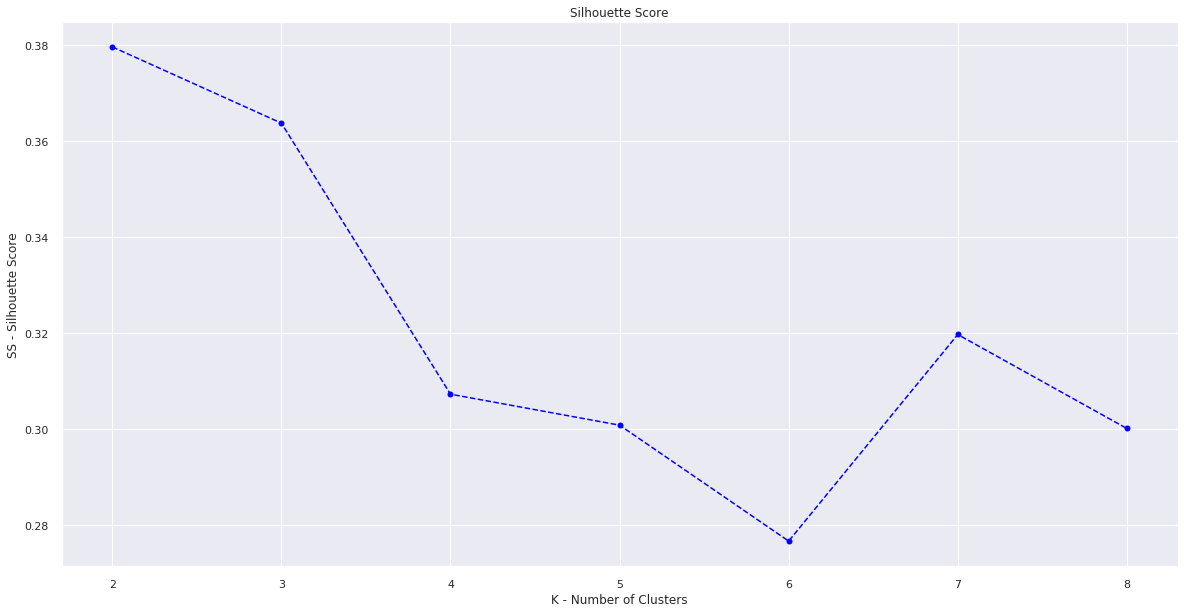

In [59]:
plt.plot( clusters, silhouette_list, linestyle='--', marker='o', color='blue' );
plt.xlabel('K - Number of Clusters')
plt.ylabel('SS - Silhouette Score')
plt.title('Silhouette Score');

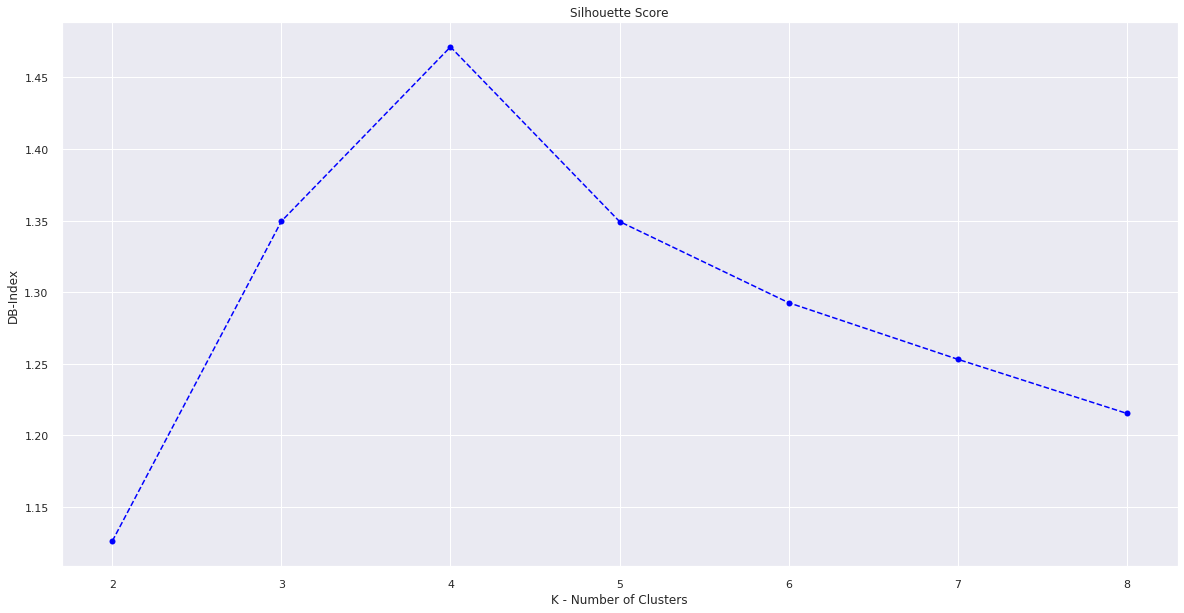

In [60]:
plt.plot( clusters, davies_list, linestyle='--', marker='o', color='blue' );
plt.xlabel('K - Number of Clusters')
plt.ylabel('DB-Index')
plt.title('Silhouette Score');

## 7.1 Silhouette Analysis

NameError: name 'kmeans' is not defined

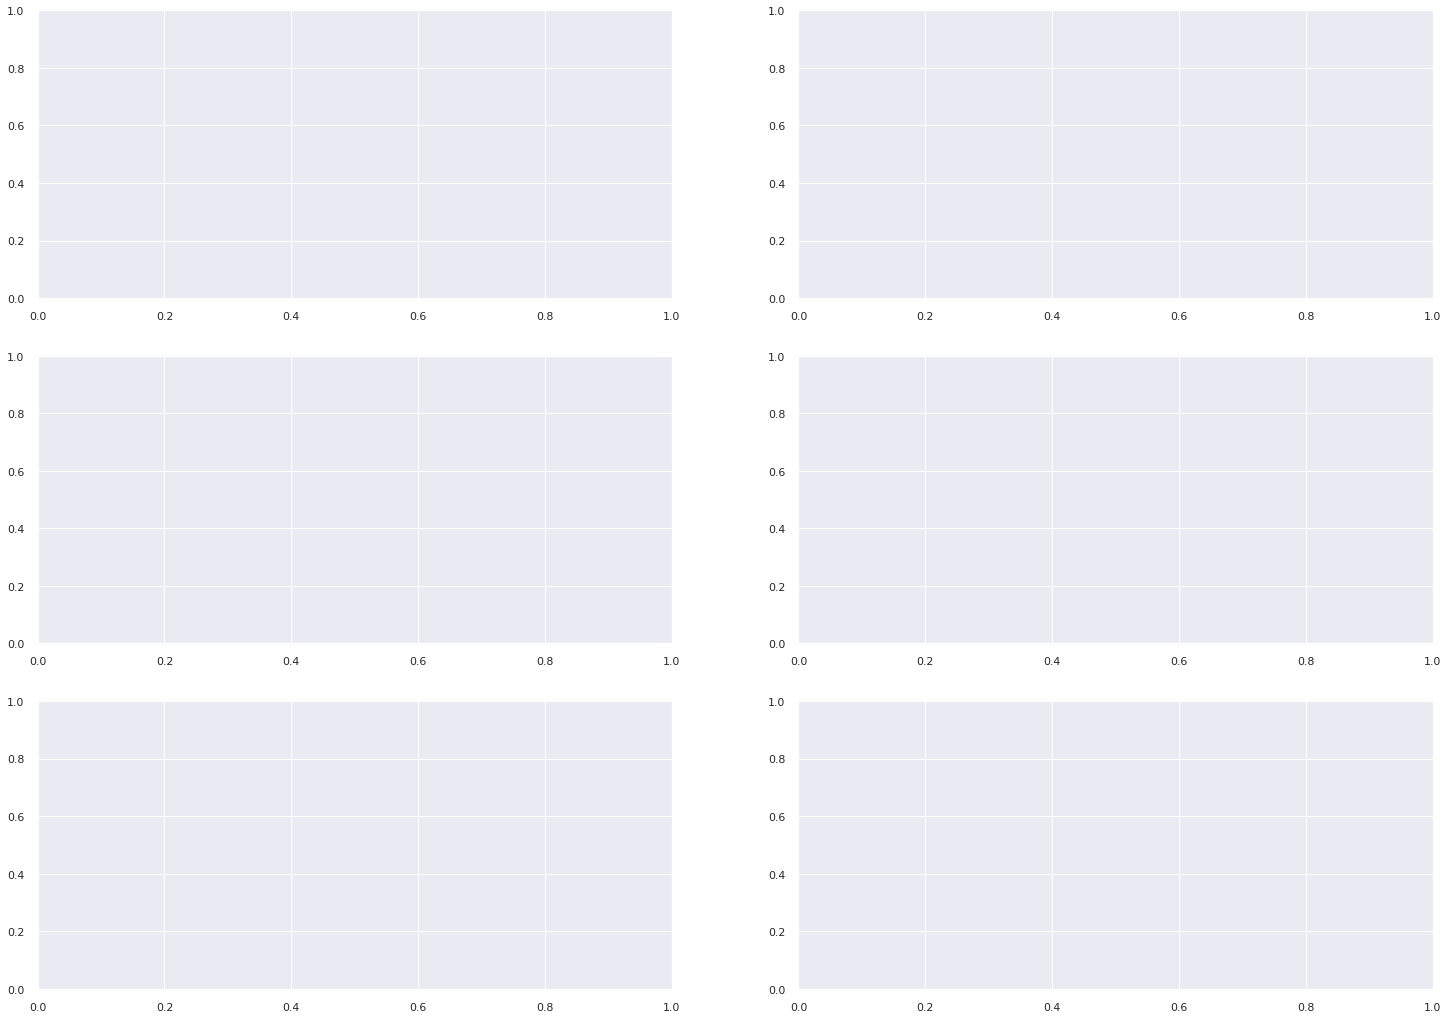

In [43]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    labels = kmeans.labels_
    db(X, labels)
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( df7 )
    visualizer.finalize();

## 7.2 DBscan Analysis

In [31]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import davies_bouldin_score as db

In [34]:
# No DB-index procuramos os cluster mais próximos de zero.
# Esse índice significa a 'similaridade' média entre os clusters, 
#em que a similaridade é uma medida que compara a distância entre 
#os clusters com o tamanho dos próprios clusters.
# Um índice Davies-Bouldin mais baixo está relacionado a um modelo com melhor separação entre os clusters.

kmeans = c.KMeans(n_clusters=3, random_state=1).fit(df7)
labels = kmeans.labels_
db(df7, labels)

1.1904352423164577

In [ ]:
# Nesse ponto, temos uma métrica muito alta no DB-scan que significa uma similiaridade muita baixa entre os Clusters

# 8.0 Model Training

In [35]:
df8 = df7.copy()

## 8.2. Cluster Validation

In [ ]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( df7, labels, metric='euclidean' ) ) )

# 9.0 Cluster Analysis

In [17]:
df9 = df1.copy()

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit(df7)
visualizer.finalize()

## 9.2 2d Plot

In [ ]:
df_viz = df9.drop( columns='cust_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3 UMAP

In [ ]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( df7 )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [ ]:
df9.head()

In [ ]:
# Number of customer
df_cluster = df9[['cust_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['cust_id'] / df_cluster['cust_id'].sum() )

df_cluster

# 10.0 Deploy

In [ ]:
df10 = df9.copy()